In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-05-23 16:42:11,648 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-05-23 16:42:11,648 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-05-23 16:42:12,112 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2024-05-23 16:42:12,118 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2024-05-23 16:42:12,121 - matplotlib - DEBUG - interactive is False
2024-05-23 16:42:12,122 - matplotlib - DEBUG - platform is linux
2024-05-23 16:42:12,187 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2024-05-23 16:42:12,194 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json


# Load data

In [3]:
import os

os.path.basename(
    "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/peak_selection_model_1out32_lr01.yaml"
)[:-5]

'peak_selection_model_1out32_lr01'

In [3]:
peak_selection_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/peak_selection_model_1out32_lr01"
result_dir = os.path.dirname(peak_selection_dir)

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from peak_detection_2d.model import PeakDetectionNet

model = PeakDetectionNet(1, 32)
model.load_state_dict(torch.load(os.path.join(peak_selection_dir, "best_model.pt")))
model.eval()
model.to(device)

<All keys matched successfully>

PeakDetectionNet(
  (conv): Sequential(
    (0): ResBlock(
      (base1): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (base2): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (base1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (base2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNor

PeakDetectionNet(
  (conv): Sequential(
    (0): ResBlock(
      (base1): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (base2): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (base1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (base2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNor

In [6]:
import torch
from torchvision.transforms import Compose
from peak_detection_2d.utils import (
    plot_sample_predictions,
    plot_history,
)
from peak_detection_2d.dataset import MultiHDF5Dataset, Padding, ToTensor

num_epoch = 100
patience = 10
inital_lr = 0.1
batch_size = 512

random_state = 42


hdf5_files = [
    os.path.join(os.path.join(result_dir, "peak_detection_data"), file)
    for file in os.listdir(os.path.join(result_dir, "peak_detection_data"))
]

# Define transformations (if any)
transformation = Compose([Padding((180, 180)), ToTensor(scale_label=False)])

# Create the dataset
dataset = MultiHDF5Dataset(hdf5_files, transforms=transformation)

# Split the dataset into training and testing sets
train_val_dataset, test_dataset = dataset.split_dataset(
    train_ratio=0.9, seed=random_state
)
train_dataset, val_dataset = train_val_dataset.split_dataset(
    train_ratio=0.9, seed=random_state
)

# Example usage
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1024, shuffle=False
)

2024-05-23 16:42:17,580 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-05-23 16:42:17,581 - h5py._conv - DEBUG - Creating converter from 5 to 7
2024-05-23 16:42:17,581 - h5py._conv - DEBUG - Creating converter from 7 to 5
2024-05-23 16:42:17,582 - h5py._conv - DEBUG - Creating converter from 5 to 7


In [7]:
train_dataset.__len__()
val_dataset.__len__()
test_dataset.__len__()

27975

3109

3454

2024-05-23 16:42:19,530 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 161]) smaller than new size, deltas 19, 87, padding image.
2024-05-23 16:42:19,531 - peak_detection_2d.dataset - DEBUG - Orginal label [-26  35  70  64]
2024-05-23 16:42:19,543 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-05-23 16:42:19,546 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-05-23 16:42:19,550 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-05-23 16:42:19,551 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-05-23 16:42

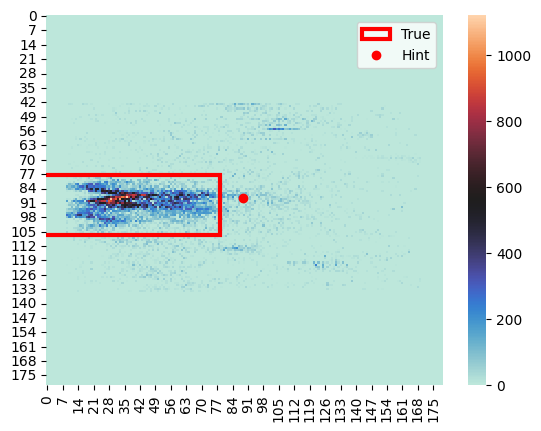

In [8]:
from peak_detection_2d.utils import plot_data_points

image, hint, label = test_dataset[3023]
to_plot = {"data": image[0].cpu(), "hint_idx": hint.cpu(), "bbox": label.cpu()}
# red_bbox=output[0].cpu().detach().numpy(),
plot_data_points(to_plot, zoom_in=False)

In [12]:
from peak_detection_2d.model import train_val_step_wiou
from peak_detection_2d.loss import WeightedBoundingBoxIoULoss

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
WIOU = WeightedBoundingBoxIoULoss(add_diou=False)
train_val_step_wiou(val_dataloader, model, WIOU)

2024-05-23 16:48:38,945 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 161]) smaller than new size, deltas 19, 87, padding image.
2024-05-23 16:48:38,946 - peak_detection_2d.dataset - DEBUG - Orginal label [28 30 76 38]
2024-05-23 16:48:38,952 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 160]) smaller than new size, deltas 20, 87, padding image.
2024-05-23 16:48:38,953 - peak_detection_2d.dataset - DEBUG - Orginal label [30 25 54 28]
2024-05-23 16:48:38,958 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 92, 92]) smaller than new size, deltas 88, 88, padding image.
2024-05-23 16:48:38,959 - peak_detection_2d.dataset - DEBUG - Orginal label [  0  24 170  51]
2024-05-23 16:48:38,964 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 161]) smaller than new size, deltas 19, 87, padding image.
2024-05-23 16:48:38,965 - peak_detection_2d.dataset - DEBUG - Orginal label [37 41 67 47]
2024-05-23 16:48:38,970 - peak_de

(0.0028450489235905905, 0.2991339247032698)

2024-05-23 16:46:25,420 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 162]) smaller than new size, deltas 18, 87, padding image.
2024-05-23 16:46:25,421 - peak_detection_2d.dataset - DEBUG - Orginal label [ 3 22 72 26]
2024-05-23 16:46:25,429 - peak_detection_2d.loss - DEBUG - intersection dimension: torch.Size([1, 1, 180, 180])
2024-05-23 16:46:25,430 - peak_detection_2d.loss - DEBUG - boxes1: torch.Size([1, 4]), boxes2: torch.Size([1, 4])


2024-05-23 16:46:25,432 - peak_detection_2d.loss - DEBUG - Intersection box: x1: tensor([34.0512], device='cuda:0', grad_fn=<MaximumBackward0>), y1: tensor([65.], device='cuda:0', grad_fn=<MaximumBackward0>), x2: tensor([61.5149], device='cuda:0', grad_fn=<MinimumBackward0>), y2: tensor([69.], device='cuda:0', grad_fn=<MinimumBackward0>)
2024-05-23 16:46:25,439 - peak_detection_2d.loss - DEBUG - Non zero count in interestion tensor(108, device='cuda:0')
2024-05-23 16:46:25,441 - peak_detection_2d.loss - DEBUG - intersection dimension: torch.Size([1, 1, 180, 180])
2024-05-23 16:46:25,443 - peak_detection_2d.loss - DEBUG - Non zero count in union tensor(345, device='cuda:0')
2024-05-23 16:46:25,444 - peak_detection_2d.loss - DEBUG - union dimension: torch.Size([1, 1, 180, 180])
2024-05-23 16:46:25,445 - peak_detection_2d.loss - DEBUG - weights dimension: torch.Size([1, 1, 180, 180])
2024-05-23 16:46:25,447 - peak_detection_2d.loss - DEBUG - intersection value tensor(5588.6079, device='cu

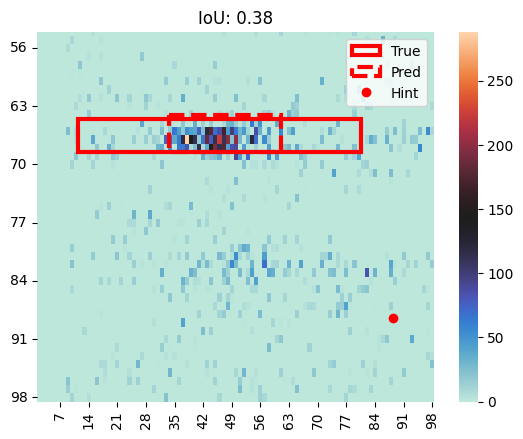

In [11]:
from peak_detection_2d.loss import WeightedBoundingBoxIoULoss

WIOU = WeightedBoundingBoxIoULoss(add_diou=False)
idx = 3286
image, hint, label = test_dataset[idx]
output = model(image.unsqueeze(0).float(), hint.unsqueeze(0).float())
wiou = WIOU.forward(
    predicted_boxes=output,
    target_boxes=label.unsqueeze(0),
    target_heatmap=image.unsqueeze(0).float(),
)
plot_sample_predictions(
    test_dataset,
    model=model,
    sample_indices=[idx],
    save_dir=None
    # save_dir=os.path.join(result_dir, "peak_selection_model", "sample_predictions"),
)

2024-05-23 16:32:28,778 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 162]) smaller than new size, deltas 18, 87, padding image.
2024-05-23 16:32:28,779 - peak_detection_2d.dataset - DEBUG - Orginal label [ 3 22 72 26]
2024-05-23 16:32:29,625 - peak_detection_2d.loss - DEBUG - intersection dimension: torch.Size([1, 1, 180, 180])
2024-05-23 16:32:29,628 - peak_detection_2d.loss - DEBUG - boxes1: torch.Size([1, 4]), boxes2: torch.Size([1, 4])
2024-05-23 16:32:29,630 - peak_detection_2d.loss - DEBUG - Intersection box: x1: tensor([34.0512], device='cuda:0', grad_fn=<MaximumBackward0>), y1: tensor([65.], device='cuda:0', grad_fn=<MaximumBackward0>), x2: tensor([61.5149], device='cuda:0', grad_fn=<MinimumBackward0>), y2: tensor([69.], device='cuda:0', grad_fn=<MinimumBackward0>)
2024-05-23 16:32:29,637 - peak_detection_2d.loss - DEBUG - Non zero count in interestion tensor(108, device='cuda:0')
2024-05-23 16:32:29,638 - peak_detection_2d.loss - DEBUG - intersection dim

tensor(0.1606, device='cuda:0', grad_fn=<MeanBackward0>)

2024-05-23 16:32:29,657 - peak_detection_2d.dataset - DEBUG - Image size torch.Size([1, 93, 162]) smaller than new size, deltas 18, 87, padding image.
2024-05-23 16:32:29,658 - peak_detection_2d.dataset - DEBUG - Orginal label [ 3 22 72 26]
2024-05-23 16:32:29,699 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f5c1a2ce260>
2024-05-23 16:32:29,893 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-23 16:32:29,894 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-05-23 16:32:29,894 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplo

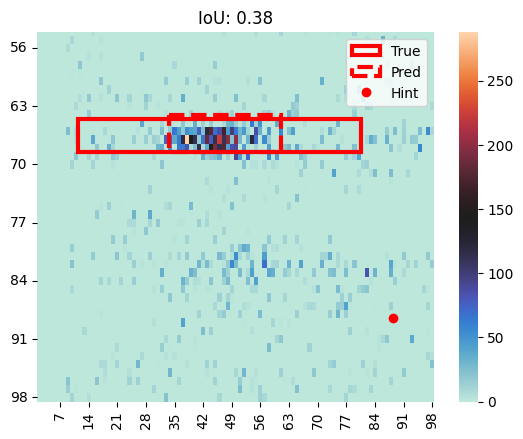

In [9]:
from peak_detection_2d.loss import WeightedBoundingBoxIoULoss

WIOU = WeightedBoundingBoxIoULoss(add_diou=True)
idx = 3286
image, hint, label = test_dataset[idx]
output = model(image.unsqueeze(0).float(), hint.unsqueeze(0).float())
WIOU.forward(
    predicted_boxes=output,
    target_boxes=label.unsqueeze(0),
    target_heatmap=image.unsqueeze(0).float(),
)
plot_sample_predictions(
    test_dataset,
    model=model,
    sample_indices=[idx],
    save_dir=None
    # save_dir=os.path.join(result_dir, "peak_selection_model", "sample_predictions"),
)

In [9]:
# import gc

# torch.cuda.empty_cache()
# gc.collect()

2024-05-23 11:47:43,307 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f533951ceb0>
2024-05-23 11:47:43,500 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-23 11:47:43,501 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-05-23 11:47:43,502 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-23 11:47:43,502 - matplotlib.font_manager - DEBUG - findfont: sco

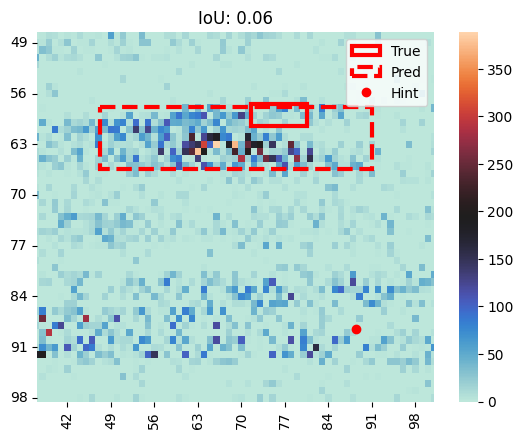

In [10]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions

# Plot sample predictions
plot_sample_predictions(
    test_dataset,
    model=model,
    sample_indices=[2],
    save_dir=None
    # save_dir=os.path.join(result_dir, "peak_selection_model", "sample_predictions"),
)

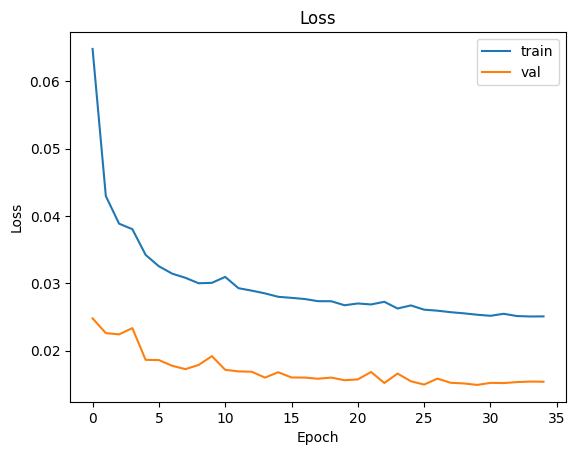

In [201]:
plot_history(loss_tracking, "Loss")

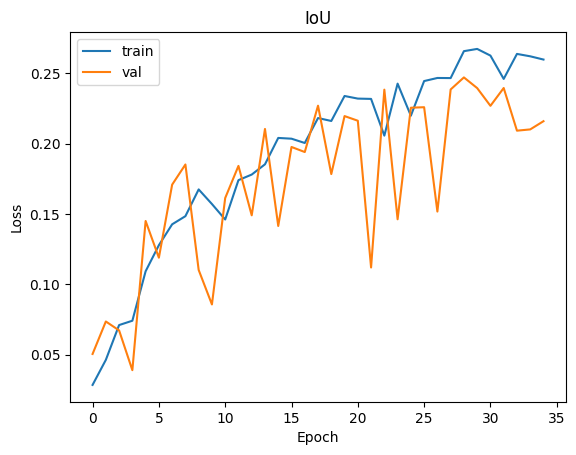

In [202]:
plot_history(iou_tracking, "IoU")

In [178]:
import gc

torch.cuda.empty_cache()
gc.collect()

1898

2024-05-22 13:04:25,673 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2429cad4e0>


Text(0.5, 1.0, 'IoU: 0.33')

2024-05-22 13:04:26,353 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2428bc9210>


Text(0.5, 1.0, 'IoU: 0.19')

2024-05-22 13:04:27,093 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2427a1acb0>


Text(0.5, 1.0, 'IoU: 0.20')

2024-05-22 13:04:28,008 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2426aa42b0>


Text(0.5, 1.0, 'IoU: 0.66')

2024-05-22 13:04:29,023 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2425afd5d0>


Text(0.5, 1.0, 'IoU: 0.06')

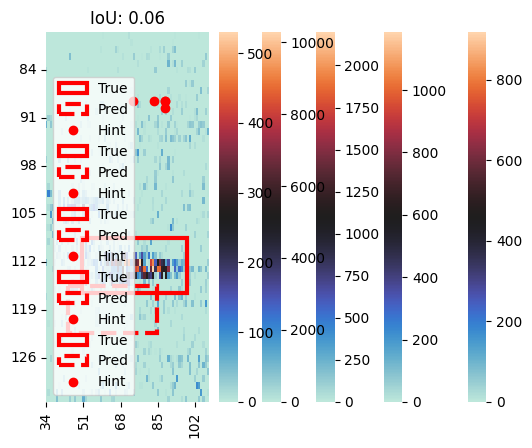

In [190]:
from peak_detection_2d.utils import plot_data_points

# Sample n datapoints from test_dataset
n = 5
sample_indices = np.random.choice(len(test_dataset), n, replace=False)
for i in sample_indices:
    image, hint, label = test_dataset[i]
    output = model(image.unsqueeze(0).float(), hint.unsqueeze(0).float())
    iou = iou_batch(output, label.unsqueeze(0))
    to_plot = {"data": image[0].cpu(), "hint_idx": hint.cpu(), "bbox": label.cpu()}
    plot_data_points(to_plot, pred_bbox=output[0].cpu().detach().numpy(), zoom_in=True)
    plt.title(f"IoU: {iou:.2f}")
    plt.savefig(f"sample_{i}.png", dpi=300)
    plt.close()